In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import warnings
import re
import html
import unidecode

from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
billboard = pd.read_csv('../data/billboard.csv')
billboard.sample(5)

,index,rank,song,artist_base,artist_all,year,artist_featured
7,7,8,the middle,zedd,"zedd , maren morris and grey",2018,NaN
28,28,29,let you down,nf,nf,2018,NaN
380,80,81,one too many,keith urban,keith urban and pink,2021,NaN
135,35,36,"break up with your girlfriend, i'm bored",ariana grande,ariana grande,2019,NaN
325,25,26,up,cardi b,cardi b,2021,NaN


In [3]:
def clean_song(x):
    x = x.replace('-', ' ')
    x = x.replace('&', 'and')
    x = re.sub(r'[^\w\s]','', x)
    x = unidecode.unidecode(x)
    return x

billboard[['artist_base']]\
    = billboard[['artist_base']].applymap(
        lambda x: x.replace('&', 'and'))

billboard[['song_clean', 'artist_clean']]\
    = billboard[['song', 'artist_base']].applymap(clean_song)

billboard.sample(5)

,index,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean
102,2,3,without me,halsey,halsey,2019,NaN,without me,halsey
393,93,94,happier than ever,billie eilish,billie eilish,2021,NaN,happier than ever,billie eilish
287,87,88,be like that,kane brown,"kane brown , swae lee and khalid",2020,NaN,be like that,kane brown
121,21,22,girls like you,maroon 5,maroon 5 featuring cardi b,2019,cardi b,girls like you,maroon 5
431,31,32,numb little bug,em beihold,em beihold,2022,NaN,numb little bug,em beihold


In [4]:
billboard.loc[44]

index                             44
rank                              45
song                         him & i
artist_base                   g-eazy
artist_all         g-eazy and halsey
year                            2018
artist_featured                  NaN
song_clean                 him and i
artist_clean                  g eazy
Name: 44, dtype: object

In [71]:
genius_url = 'https://genius.com/Gunna-and-future-pushin-p-lyrics'

html = requests.get(url=genius_url).content
soup = bs4.BeautifulSoup(html)

lyrics = soup\
  .find('div', {'class': 'Lyrics__Container-sc-1ynbvzw-5'})\
  .findAll(text=True)
                
print(lyrics)

['[Intro: Gunna & ', 'Future', ']', '(', 'Wheezy outta here', ')', "Pushin' P", "Yeah, pushin' P, turn me up", 'Turn me up, P, uh-ah', '[Verse 1: Gunna & ', 'Future', ']', "Pointers in the Patek and my piece, I'm pushin' P", "Copped new hammers for my P, we don't want no peace", "Got a spot across the spot, just for P's", "Dropped the dot and then we plot, exotic P's", 'She not a lesbian, for P, she turn Pesbian', ' (', "Pushin' P", ", I'm pushin' P)", 'Off capital P, I rock these presidents, count presidents (', "Pushin' P", ')', "Portuguese on her knees, moppin' down the P", "She let me squeeze, then she lеave 'cause she keep it P", "Privatе suite, private seat, bitch, I'm pushin' P", "Purple pint, pussy pink, bitch, I'm pushin' P", '[Chorus: Gunna & ', 'Future', ']', "Pushin' P", ", I'm pushin' P, ", "pushin' P", ", I'm pushin' P, ", 'yeah', " (Know what I'm sayin')", "Pushin' P", ", I'm pushin' P, ", "pushin' P", ", I'm pushin' P, ", 'yeah', "Pop a P, I'm paranoid, I can't just sle

In [13]:
lyrics_list = list() # collector for lyric strings or None if no lyrics found
source_list = list() # collector for the URL from which lyrics were obtained

for index, row in billboard.iterrows():
    artist = row['artist_clean']
    artist_2 = re.sub(r'^the ', '', row['artist_clean']) # if initial round fails
    artist_3 = row['artist_all']
    song = row['song_clean']
    source = None
    
    # generate URLs for each website. some uses dashes in place of 
    # whitespaces, others use underscores
    urls = list()
    genius_url = 'https://genius.com/{}-{}-lyrics'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    urls.extend([genius_url, song_url])
    if artist != artist_2:
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        urls.extend([genius_url, song_url])
    if artist != artist_3:
        print(artist_3)
        
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist_3.replace(' ', '-'), song.replace(' ', '-'))
        print(genius_url)
        
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist_3.replace(' ', '-'), song.replace(' ', '-'))
        urls.extend([genius_url, song_url])
    
    # attempt scrape and parse sequence. lyrics collected as list of tokens.
    for url in urls:
        try:
            # request HTML and parse
            html = requests.get(url=url).content
            soup = bs4.BeautifulSoup(html)
            
            # find lyrics and pre-process
            if 'genius.com' in url:
                print(url)
                lyrics = soup\
                    .find('div', {'class': 'Lyrics__Container-sc-1ynbvzw-5'})\
                    .findAll(text=True)
                if lyrics is None:
                    raise Exception
                else:
                    source = 'genius.com'
                    print(song)
                    print(lyrics)
                    break
                
            # for songlyrics.com, if no lyrics found, a message is displayed
            # where lyrics would be. thus, we check for this message instead.
            if 'songlyrics' in url:
                print(url)
                lyrics = soup\
                    .find('p', {'id': 'songLyricsDiv'})\
                    .findAll(text=True)
                if 'Sorry, we have no ' in lyrics[0]:
                    lyrics = None
                    raise Exception
                else:
                    source = 'songlyrics.com'
                    break
            
            break
        except:
            print(f'{song} error')
    lyrics_list.append(lyrics)
    source_list.append(source)

2
https://genius.com/drake-gods-plan-lyrics
gods plan
['[Intro]', "And they wishin' and wishin'", "And wishin' and wishin', they wishin' on me", 'Yeah', '[Verse 1]', "I been movin' calm, don't start no trouble with me", 'Tryna keep it peaceful is a struggle for me', "Don't pull up at 6 AM to cuddle with me", "You know how I like it when you lovin' on me", "I don't wanna die for them to miss me", "Yes, I see the things that they wishin' on me", 'Hope I got some brothers that outlive me', "They gon' tell the story, shit was different with me", '[Chorus]', "God's plan, God's plan", "I hold back, sometimes I won't, yeah", "I feel good, sometimes I don't (Ayy, don't)", "I finessed down Weston Road (Ayy, 'nessed)", 'Might go down a G.O.D. (Yeah, wait)', 'I go hard on Southside G (Yeah, wait)', 'I make sure that north-side eat', 'And still', '[Post-Chorus]', 'Bad things', "It's a lot of bad things that they wishin' and wishin'", "And wishin' and wishin', they wishin' on me", 'Bad things', "It

In [6]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'\[[^]]*\]' , ' ', lyrics)
    print((lyrics))
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = np.nan
    return lyrics

In [15]:
lyrics_list_clean = list(map(clean_lyrics, lyrics_list))
billboard['lyrics'] = lyrics_list_clean
billboard['source'] = source_list

  And they wishin and wishin And wishin and wishin, they wishin on me Yeah   I been movin calm, dont start no trouble with me Tryna keep it peaceful is a struggle for me Dont pull up at 6 AM to cuddle with me You know how I like it when you lovin on me I dont wanna die for them to miss me Yes, I see the things that they wishin on me Hope I got some brothers that outlive me They gon tell the story, shit was different with me   Gods plan, Gods plan I hold back, sometimes I wont, yeah I feel good, sometimes I dont (Ayy, dont) I finessed down Weston Road (Ayy, nessed) Might go down a G.O.D. (Yeah, wait) I go hard on Southside G (Yeah, wait) I make sure that north-side eat And still   Bad things Its a lot of bad things that they wishin and wishin And wishin and wishin, they wishin on me Bad things Its a lot of bad things that they wishin and wishin And wishin and wishin, they wishin on me Yeah, ayy, ayy
  I found a love for me Oh, darlin, just dive right in and follow my lead Well, I found 

In [16]:
lyrics = billboard['lyrics'].dropna()
for each in lyrics[lyrics.str.contains('chorus')]:
    print([each])

[' you promised the world and i fell for it i put you first and you adored it set fires to my forest and you let it burn sang off key in my chorus cause it wasnt yours i saw the signs and i ignored it rose colored glasses all distorted set fire to my purpose and i let it burn you got off on the hurtin when it wasnt yours yeah wed always go into it blindly i needed to lose you to find me this dancing was killing me softly i needed to hate you to love me yeah to love love yeah to love love yeah to love yeah i needed to lose you to love me yeah to love love yeah to love love yeah to love yeah i needed to lose you to love me']
[' car rides to malibu strawberry ice cream one spoon for two and tradin jackets laughin bout how small it looks on you ha ha ha ha ha ha ha ha ha ha ha ha ha watching reruns of glee bein annoying singin in harmony i bet shes braggin to all her friends sayin youre so unique hmm so when you gonna tell her that we did that too she thinks its special but its all reused 

[Text(0, 0.5, 'Proportion of All Hot 100 Songs'),
 Text(0.5, 1.0, 'Distribution of Song Lyric Sources')]

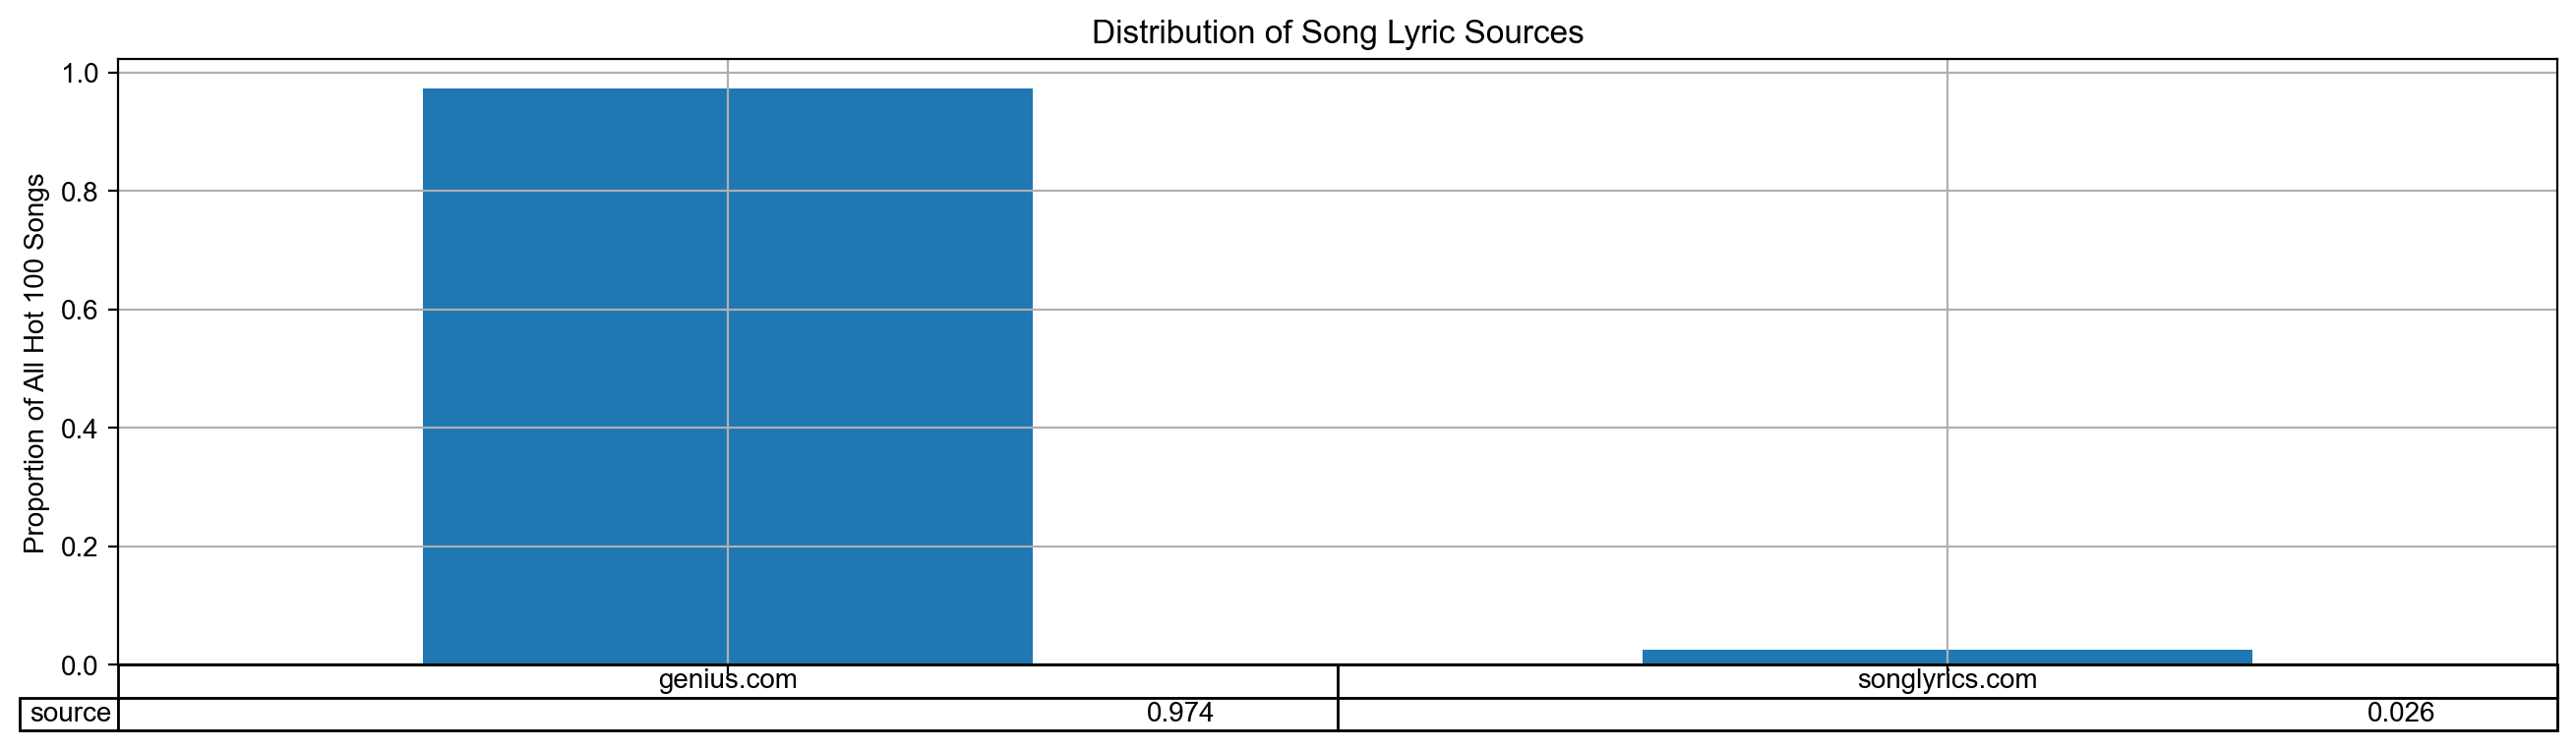

In [92]:
ax = (billboard['source'].value_counts() / len(billboard)).plot.bar(
    table=True, figsize=(16,4))
ax.grid(True)
ax.set_xticklabels([])
ax.set(ylabel='Proportion of All Hot 100 Songs',
       title='Distribution of Song Lyric Sources')

In [87]:
billboard['source'].isnull().sum()

10

In [77]:
billboard['lyrics'].isnull().sum() / len(billboard)

0.0

In [255]:
url = 'https://genius.com/marvin-gaye-pride-and-joy-lyrics'
html = requests.get(url=url).content
soup = bs4.BeautifulSoup(html)
lyrics = soup.find('div', {'class': 'lyrics'}).find('p').findAll(text=True)

In [20]:
billboard.to_csv('../data/billboard-lyrics.csv', index=False)